In [1]:
include("../../src/WaterLily.jl")
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD
using Images
using FFTW
using Statistics
using Interpolations
using DelimitedFiles
using LinearAlgebra
using PyPlot
using GLMakie
GLMakie.activate!()
using PlotlyJS

In [2]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))
@inline CI(a...) = CartesianIndex(a...)
"""
    δ(i,N::Int)
    δ(i,I::CartesianIndex{N}) where {N}

Return a CartesianIndex of dimension `N` which is one at index `i` and zero elsewhere.
"""
δ(i,::Val{N}) where N = CI(ntuple(j -> j==i ? 1 : 0, N))
δ(i,I::CartesianIndex{N}) where N = δ(i, Val{N}())

δ (generic function with 2 methods)

In [3]:
computationID = "DamBreak"
N = 32
lx = ((1:N).-0.5)/N
ly = ((1:N).-0.5)/N

0.015625:0.03125:0.984375

In [4]:
function hydroDynP!(sim)
    ρ = sim.inter.f[2:end-1,2:end-1,2:end-1]*(1-sim.inter.λρ).+sim.inter.λρ
    cumsumρ = cumsum(ρ,dims=3)
    sumρ = sum(ρ,dims=3)
    cumsumρ = sumρ .- cumsumρ 
    sim.flow.σ[2:end-1,2:end-1,2:end-1] .= ((sim.flow.p[2:end-1,2:end-1,2:end-1]+sim.flow.p[2:end-1,2:end-1,1:end-2])/2 + cumsumρ*sim.flow.g[3])/(0.5sim.U^2)
end

hydroDynP! (generic function with 1 method)

In [5]:
function flood(f::Array;shift=(0.,0.),cfill=:RdBu_11,clims=(),levels=10,kv...)
    if length(clims)==2
        @assert clims[1]<clims[2]
        @. f=min(clims[2],max(clims[1],f))
    else
        clims = (minimum(f),maximum(f))
    end
    Plots.contourf(axes(f,1).+shift[1],axes(f,2).+shift[2],f',
        linewidth=0, levels=levels, color=cfill, clims = clims, 
        aspect_ratio=:equal; kv...)
    Plots.contour!(axes(f,1).+shift[1],axes(f,2).+shift[2],f',
        linewidth=2, levels=[0.5], color=:black)
end

addbody(x,y;c=:black) = Plots.plot!(Shape(x,y), c=c, legend=false)
function body_plot!(sim;levels=[0],lines=:black,R=inside(sim.flow.p))
    WaterLily.measure_sdf!(sim.flow.σ,sim.body,WaterLily.time(sim))
    Plots.contour!(sim.flow.σ[R]';levels,lines)
end

function sim_gif!(sim;duration=1,step=0.1,verbose=true,R=inside(sim.flow.p),
                    remeasure=false,plotbody=false,kv...)
    t₀ = round(WaterLily.sim_time(sim))
    for I∈inside(sim.flow.σ)
        sim.flow.σ[I] = WaterLily.div(I,sim.flow.u)
    end
    diver = [Statistics.sum(abs.(sim.flow.σ[R]))]
    mass = [Statistics.mean(sim.inter.f[R])]
    maxU = [maximum(sqrt.(Statistics.sum(sim.flow.u.^2,dims=4)))]
    @time @gif for tᵢ in range(t₀,t₀+duration;step)
        try
            WaterLily.sim_step!(sim,tᵢ;remeasure)
        catch y
            println(y)
            return diver,mass,maxU
        end
        
        for I∈inside(sim.flow.σ)
            sim.flow.σ[I] = WaterLily.div(I,sim.flow.u)
        end
        push!(diver,maximum(abs.(sim.inter.f[R].*sim.flow.σ[R])))
        push!(mass,Statistics.mean(sim.inter.f[R]))
        push!(maxU,maximum(sqrt.(Statistics.sum(sim.flow.u.^2,dims=4))))
        ff = sim.inter.f[R]
        # hydroDynP!(sim)
        sim.flow.σ .=0
        for I∈inside(sim.flow.σ)
            for i ∈ 1:3
                sim.flow.σ[I] += (sim.flow.u[I,i]+sim.flow.u[I+δ(i,I),i]).^2
            end
        end
        sim.flow.σ .= sqrt.(sim.flow.σ)/2/sim.U
        sim.flow.σ .= sim.flow.p/(0.5sim.U^2)
        # Plots.contourf(lx,ly.-0.5/N,clamp.(sim.flow.σ[4,2:end-1,2:end-1]',0,2), aspect_ratio=:equal,color=:seismic,levels=60,xlimit=[0,1],ylimit=[0,1],linewidth=0,clim=(0,2))
        Plots.contourf(lx.-0.5/N,ly,clamp.(sim.flow.u[4,2:end-1,2:end-1,2]'/sim.U,-2,2), aspect_ratio=:equal,color=:seismic,levels=60,xlimit=[0,1],ylimit=[0,1],linewidth=0,clim=(-2,2))
        Plots.contour!(lx,ly,sim.inter.f[4,2:end-1,2:end-1]', aspect_ratio=:equal,color=:Black,levels=[0.5],xlimit=[0,1],ylimit=[0,1],linewidth=2)
        # flood(sim.flow.σ[R]; kv...)
        # flood(sim.inter.f[4,2:end-1,2:end-1]; kv...)
        # Plots.heatmap(lx,ly,log10.(abs.(sim.inter.f[4,2:end-1,2:end-1]').+1e-10), aspect_ratio=:equal,color=:Spectral,xlimit=[0,1],ylimit=[0,1],linewidth=0)
        # flood(sim.flow.p[R].-Statistics.mean(sim.flow.p[R]); kv...)
        # StaggerToCollocateVel!(sim.flow.u,uInside)
        # flood(sqrt.(sum(uInside.^2,dims=[3]))[:,:,1]; kv...)
        plotbody && body_plot!(sim)
        verbose && println("tU/L=",round(tᵢ,digits=4),
            ", Δt=",round(sim.flow.Δt[end],digits=3))
    end
    return diver,mass,maxU
end

sim_gif! (generic function with 1 method)

In [7]:
function printSurU(I,u)
    N,n = WaterLily.size_u(u)
    for i in 1:n
        print("u$i: ", u[I,i], ", ", u[I+δ(i,I),i],"\n")
    end
    print("∇⋅u: ",WaterLily.div(I,u),"\n")
end

printSurU (generic function with 1 method)

In [8]:
function damBreak(LDomain;Re=1000,Fr=1,g=9.81)
    N = (8,LDomain,LDomain)
    H = LDomain/2
    LScale = H
    UScale = sqrt(g*LScale)*Fr
    ν = UScale*LScale/Re

    function interSDF(xx)
        x,y,z = @. xx-1.5
        if y<=H && z <= H
            return max(y-H,z-H)
        elseif y<=H && z > H
            return z-H
        elseif y>H && z <= H
            return y-H
        elseif y>H && z > H
            return sqrt((z-H)^2+(y-H)^2)
        end
    end

    return WaterLily.TwoPhaseSimulation(N, (0,0,0), LScale;U=UScale, Δt=0.01,grav=(0,0,-g), ν=ν, InterfaceSDF=interSDF, T=Float64)
end

damBreak (generic function with 1 method)

In [9]:
sim = damBreak(N)

Main.WaterLily.TwoPhaseSimulation(12.52836781069266, 16.0, 1, Main.WaterLily.Flow{3, Float64, Array{Float64, 3}, Array{Float64, 4}, Array{Float64, 5}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0

In [10]:
# WaterLily.mom_step!(sim.flow,sim.pois,sim.inter,sim.body)

In [11]:
# WaterLily.vof_smooth!(2, sim.inter.f, sim.inter.fᶠ, sim.inter.α)

In [12]:
for I∈inside(sim.flow.σ)
    sim.flow.σ[I] = WaterLily.div(I,sim.flow.u)
end

In [13]:
Statistics.sum(sim.flow.σ[2:end-1,2:end-1,2:end-1])/eps(Float64)

0.0

In [14]:
Statistics.sum(sim.flow.u[4,end,2:end-1,2].== 0.0)

32

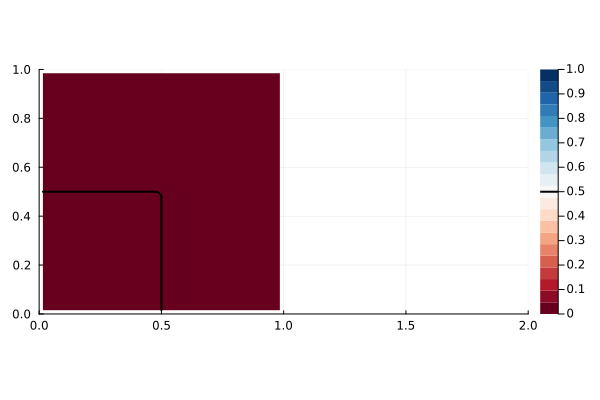

In [15]:

# hydroDynP!(sim)
Plots.plot()
Plots.contourf(lx,ly,sim.inter.f[4,2:end-1,2:end-1]', aspect_ratio=:equal,color=:RdBu,xlimit=[0,2],ylimit=[0,1],linewidth=0,clims=(0,1),levels=0.0:0.1:1.0)
# Plots.contourf!(lx,ly,log10.(abs.(sim.flow.σ[4,2:end-1,2:end-1]))', aspect_ratio=:equal,color=:RdBu,xlimit=[0,2],ylimit=[0,1],linewidth=0)
# Plots.contourf!(lx,ly.-0.5/N,sim.flow.σ[4,2:end-1,2:end-1]', aspect_ratio=:equal,color=:RdBu,xlimit=[0,2],ylimit=[0,1],linewidth=0)
# Plots.heatmap!(lx,ly,log10.(abs.(fσ[4,2:end-1,2:end-1]).+1e-20)', aspect_ratio=:equal,color=:RdBu,xlimit=[0,2],ylimit=[0,1],linewidth=0)
# Plots.contourf(lx,ly,sim.inter.f[4,2:end-1,2:end-1]', aspect_ratio=:equal,color=:RdBu,levels=20,xlimit=[0,2],ylimit=[0,1],linewidth=0,clims=(0,1))
# Plots.contourf(lx,ly,sim.flow.p[3,2:end-1,2:end-1]', aspect_ratio=:equal,color=:RdBu,levels=20,xlimit=[0,2],ylimit=[0,1],linewidth=0)
# Plots.contourf(lx,ly,sim.flow.μ₀[4,2:end-1,2:end-1,1]', aspect_ratio=:equal,color=:RdBu,levels=20,xlimit=[0,2],ylimit=[0,1],linewidth=0)
# Plots.contourf(lx,ly,sim.pois.L[4,2:end-1,2:end-1,3]', aspect_ratio=:equal,color=:RdBu,levels=20,xlimit=[0,2],ylimit=[0,1],linewidth=0)
Plots.contourf(lx,ly,sim.flow.u[4,2:end-1,2:end-1,2]', aspect_ratio=:equal,color=:RdBu,levels=20,xlimit=[0,2],ylimit=[0,1],linewidth=0)
Plots.contour!(lx,ly,sim.inter.f[4,2:end-1,2:end-1]', aspect_ratio=:equal,color=:Black,levels=[0.5],xlimit=[0,2],ylimit=[0,1],linewidth=2)
# Plots.scatter!([ly[24]],[lx[5]],markersize=1)

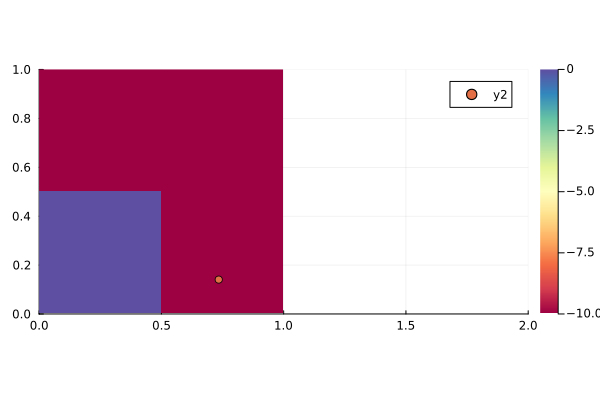

In [16]:
fPlay = copy(sim.inter.f)
Plots.heatmap(lx,ly,log10.(abs.(fPlay[4,2:end-1,2:end-1]').+1e-10), aspect_ratio=:equal,color=:Spectral,xlimit=[0,2],ylimit=[0,1],linewidth=0)
Plots.scatter!([ly[24]],[lx[5]])

In [17]:
sim.flow.σ[:,23,4]
maximum(abs.(sim.flow.σ[2:end-1,2:end-1,2:end-1]))
fσ = sim.flow.σ.*sim.inter.f;

In [18]:
size(sim.inter.f[4,2:end-1,2:end-1])

(32, 32)

In [19]:
diver,mass,maxU = sim_gif!(sim,duration=1, step=0.01,clims=(0,1),plotbody=false,verbose=false,levels=0.0:0.05:1.0,remeasure=false,cfill=:RdBu,linewidth=2,xlimit=[0,32],ylimit=[0,32],shift=(-0.5,-0.5));

 20.858791 seconds (74.39 M allocations: 3.498 GiB, 5.11% gc time, 40.72% compilation time: <1% of which was recompilation)


┌ Info: Saved animation to /tmp/jl_8lqLk3mZG1.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/3BCH5/src/animation.jl:156


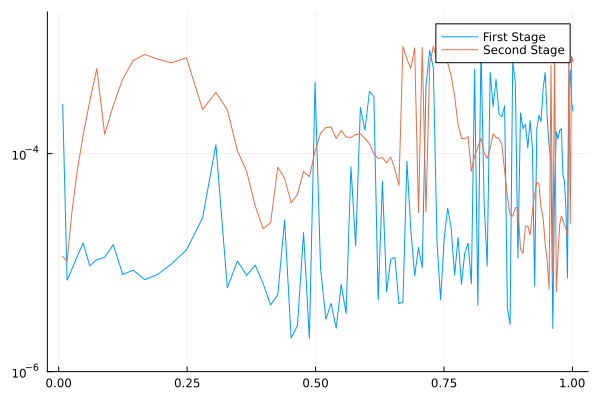

In [52]:
aa = cumsum(sim.flow.Δt)
sim.pois.n
Plots.plot(aa[1:end-1]*sim.U/sim.L,sim.pois.res[1:2:end],yscale=:log10,ylimit=[1e-6,2e-3],label="First Stage")
Plots.plot!(aa[1:end-1]*sim.U/sim.L,sim.pois.res[2:2:end],yscale=:log10,ylimit=[1e-6,2e-3],label="Second Stage")

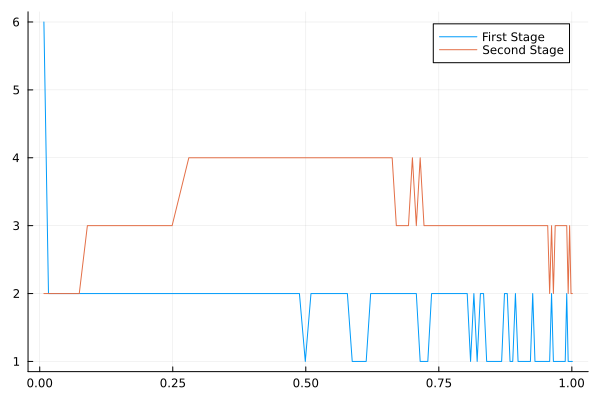

In [53]:
Plots.plot(aa[1:end-1]*sim.U/sim.L,sim.pois.n[1:2:end],label="First Stage")
Plots.plot!(aa[1:end-1]*sim.U/sim.L,sim.pois.n[2:2:end],label="Second Stage")

In [20]:
printSurU(CartesianIndex(4,20,2),sim.flow.u*sim.flow.Δt[end])
println(sim.flow.Δt[end])
println(sim.inter.fᶠ[4,20,2], " ", sim.inter.fᶠ[4,21,2])
println()

u1: 0.0, 0.0
u2: 0.030072743316848116, 0.03319099965390249
u3: 0.0, -0.0031182563795958637
∇⋅u: -4.254148639262767e-11
0.003090441979713751
1.0 1.0



In [21]:
sim.inter.f[:,24,5]

10-element Vector{Float64}:
 0.9271548030180808
 0.9271548030180808
 0.9271548030180808
 0.9271548030180808
 0.9271548030180808
 0.9271548030180808
 0.9271548030180808
 0.9271548030180808
 0.9271548030180808
 0.9271548030180808

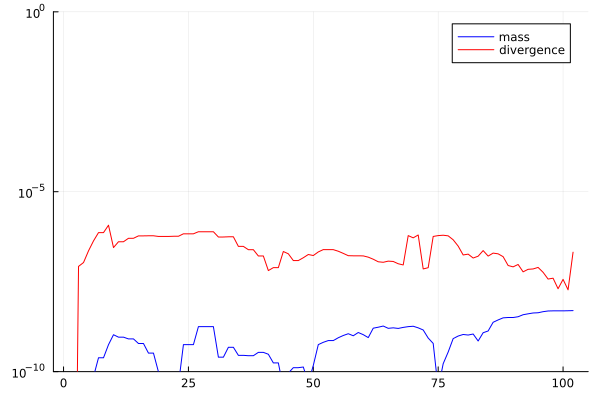

In [22]:
massrel = abs.((mass.-mass[1])/mass[1]).+1e-20
Plots.plot(massrel,yaxis=:log10,label="mass",color=:blue)
Plots.plot!(diver.+1e-20,yaxis=:log10,label="divergence",ylimit=[1e-10,1e0],color=:red)

In [23]:
massrel[end]

4.961330013496531e-9

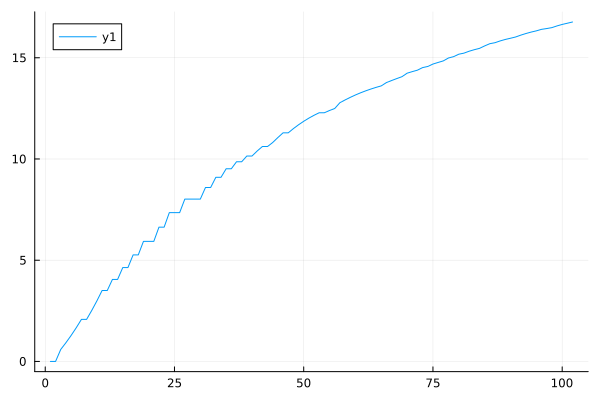

In [24]:
Plots.plot(maxU)

In [25]:
(massrel .> 1e-15)[1:20]'

1×20 adjoint(::BitVector) with eltype Bool:
 0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [26]:
# for itm ∈ 1:1
#     WaterLily.mom_step!(sim.flow,sim.pois,sim.inter,sim.body)
# end
WaterLily.sim_time(sim)
sum(sim.flow.Δt)*sim.U/sim.L
# sim.flow.Δt[end-4:end]*sim.U/sim.L

1.003346032547618

In [27]:
sim.flow.Δt
a = cumsum(sim.flow.Δt)

114-element Vector{Float64}:
 0.01
 0.021
 0.033100000000000004
 0.04641000000000001
 0.06105100000000001
 0.0771561
 0.09487171000000001
 0.11435888100000002
 0.13579476910000005
 0.15937424601000005
 ⋮
 1.2535996082161238
 1.25746022836341
 1.2611949617011788
 1.2648134855564925
 1.268324812468205
 1.2717368953873824
 1.2750570221993436
 1.2782844955489072
 1.281374937528621

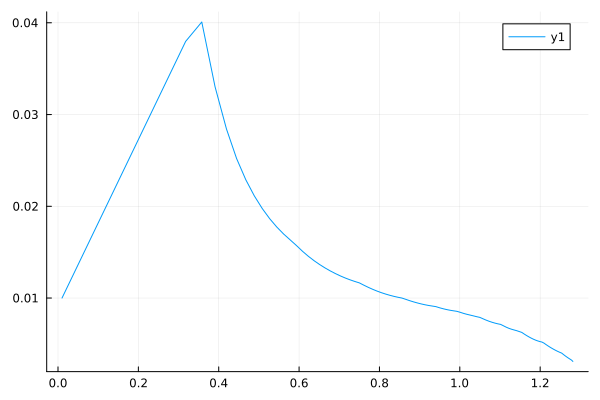

In [28]:
Plots.plot(a,sim.flow.Δt)


In [29]:
Statistics.sum(sim.inter.f[4,2:end-1,2:end-1].<0)

0

In [30]:
0.5/sim.U

0.03990942855088131